In [22]:
from typing import List, Tuple

In [23]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import spacy
from datasets import load_dataset

In [24]:
def load_sib200_ru() -> Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], List[str]]:
    # Загружаем тренировочный и валидационный наборы данных
    trainset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='train')
    valset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='validation')
    testset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='test')

    # Извлекаем текст и категории
    X_train = trainset['text']
    y_train = trainset['category']
    X_val = valset['text']
    y_val = valset['category']
    X_test = testset['text']
    y_test = testset['category']

    # Объединяем данные из train и val
    X_train = X_train + X_val
    y_train = y_train + y_val

    # Проверяем наличие неизвестных категорий
    categories = set(y_train)
    unknown_categories = set(y_test) - categories
    if len(unknown_categories) > 0:
        err_msg = f'The categories {unknown_categories} are represented in the test set, but they are not represented in the training set.'
        raise RuntimeError(err_msg)

    # Индексируем категории
    categories = sorted(list(categories))
    y_train = [categories.index(it) for it in y_train]
    y_test = [categories.index(it) for it in y_test]

    return (X_train, y_train), (X_test, y_test), categories

In [25]:
def normalize_text(s: str, nlp_pipeline: spacy.Language) -> str:
    doc = nlp_pipeline(s)
    lemmas = [('<NUM>' if token.like_num else token.lemma_.lower()) for token in filter(lambda it1: not it1.is_punct, doc)]
    if len(lemmas) == 0:
        return ''
    return ' '.join(lemmas)

In [26]:
train_data, test_data, classes_list = load_sib200_ru()

In [27]:
print(f'Categories: {classes_list}')

Categories: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']


In [28]:
print(len(train_data[0]))
print(len(train_data[1]))

800
800


In [29]:
print(len(test_data[0]))
print(len(test_data[1]))

204
204


In [30]:
nlp = spacy.load('ru_core_news_sm')

In [31]:
print(train_data[0][0])

Турция с трёх сторон окружена морями: на западе — Эгейским, на севере — Чёрным и на юге — Средиземным.


In [32]:
print(normalize_text(train_data[0][0], nlp))

турция с <NUM> сторона окружить морями на запад эгейским на север чёрный и на юг средиземный


In [33]:
print(test_data[0][0])

Мутация вносит новую генетическую вариацию, в то время как отбор убирает её из набора проявляющихся вариаций.


In [34]:
print(normalize_text(test_data[0][0], nlp))

мутация вносить новый генетический вариация в тот время как отбор убирать её из набор проявляться вариация


In [35]:
classifier = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(token_pattern='\w+')),
    ('cls', LogisticRegression(solver='saga', max_iter=100, random_state=42))
])

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\kuzga\AppData\Local\Temp\ipykernel_20336\2855085837.py:2: SyntaxWarning: invalid escape sequence '\w'
  ('vectorizer', TfidfVectorizer(token_pattern='\w+')),


In [36]:
cv = GridSearchCV(
    estimator=classifier,
    param_grid={
        'vectorizer__ngram_range': [(1, 1)],
        'vectorizer__max_df': [1.0, 0.99],
        'vectorizer__min_df': [1.0, 0.001, 0.0001],
        'cls__C': [500, 750, 1000],
        'cls__penalty': ['l1', 'l2']
    },
    scoring='f1_macro',
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=True
)

In [37]:
cv.fit([normalize_text(it, nlp) for it in train_data[0]], train_data[1])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\kuzga\OneDrive\Рабочий стол\NSU-NLP-labs\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kuzga\OneDrive\Рабочий стол\NSU-NLP-labs\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kuzga\OneDrive\Рабочий стол\NSU-NLP-labs\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kuzga\On

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='\\w+')),
                                       ('cls',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'cls__C': [500, 750, 1000],
                         'cls__penalty': ['l1', 'l2'],
                         'vectorizer__max_df': [1.0, 0.99],
                         'vectorizer__min_df': [1.0, 0.001, 0.0001],
                         'vectorizer__ngram_range': [(1, 1)]},
             scoring='f1_macro', verbose=True)

In [38]:
print('Best parameters:')
print(cv.best_params_)

Best parameters:
{'cls__C': 500, 'cls__penalty': 'l1', 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 0.001, 'vectorizer__ngram_range': (1, 1)}


In [39]:
print('Best F1-macro:')
print(cv.best_score_)

Best F1-macro:
0.6518004544730743


In [40]:
print(f'Vocabulary size is {len(cv.best_estimator_.named_steps["vectorizer"].vocabulary_)}.')

Vocabulary size is 4689.


In [41]:
y_pred = cv.predict([normalize_text(it, nlp) for it in test_data[0]])
print(classification_report(y_true=test_data[1], y_pred=y_pred, target_names=classes_list))

                    precision    recall  f1-score   support

     entertainment       0.80      0.42      0.55        19
         geography       0.75      0.53      0.62        17
            health       0.59      0.45      0.51        22
          politics       0.76      0.83      0.79        30
science/technology       0.69      0.84      0.76        51
            sports       0.87      0.80      0.83        25
            travel       0.64      0.75      0.69        40

          accuracy                           0.71       204
         macro avg       0.73      0.66      0.68       204
      weighted avg       0.72      0.71      0.70       204



Метрики оригинального пайплайна выглядели так:

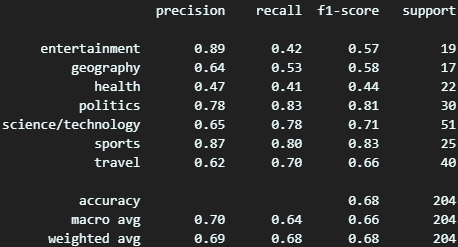